# Rational Exponent as Speed Bottleneck in Dynamic Asset Problems

Back to [**Fan**](http://fanwangecon.github.io)'s [**Matlab Examples Table of Content**](https://fanwangecon.github.io/M4Econ/)

Rational exponentiation is perhaps one of the core computational tasks in solving any dynamic models. 

It turns out, in solving a model with CRRA utility for example, the vast majority of computing time might be spent on the single task of exponentiating to a rational number.

When the exponentiation is integer based, things are quicker. Whether integer or not, exponents are dramatically more time consuming to compute than addition subtraction etc. 

For fully grid based solution algorithm, since maximization is almost instantaneous, the computing burden falls disproportionately on the exponentiation of potentially very large gridded matrixes. 

If one could compute $x^\rho$ y percent faster, that almost leads to y percent (linear) improvements in overall computing time. 

So how do we improve exponentiation time?

Well, regardless of the number of choices you have, consumption at the end, in the standard problem, enters under the rational exponent by itself. So we have a one dimensional problem. 

Imagine that we are to evaluate a 1 million (endo states) by 15 (exo shocks) matrix of consumption values, how do we make this go faster?

There is a wide variety of ways potentially. The method explored here is through 1d interpolation, which is can be extremely accurate given that we know the analytical solution to $x^\rho$. This is a trivial interpolation problem compared to interpolating over Value or Policy functions given high dimensional state space. 

Here, this problem and interpolation solution is demonstrated in the context of Matlab relevant for the second route. 

## Files

- Interpolate function testing: [**ipynb**](https://github.com/FanWangEcon/M4Econ/blob/master/support/speed/exponentiation/fs_rational_exp_interp_main.ipynb) \| [**html**](https://fanwangecon.github.io/M4Econ/support/speed/exponentiation/fs_rational_exp_interp_main.html)
- Interpolate function (griddedInterpolant): [**m**](https://github.com/FanWangEcon/M4Econ/blob/master/support/speed/exponentiation/ff_rational_exp_interp.m) \| [**html**](https://fanwangecon.github.io/M4Econ/support/speed/exponentiation/html/ff_rational_exp_interp.html)
- Direct evaluation and interpolate speed comparison:  [**m**](https://github.com/FanWangEcon/M4Econ/blob/master/support/speed/exponentiation/fs_rational_exp_interp_test.m) \| [**ipynb**](https://github.com/FanWangEcon/M4Econ/blob/master/support/speed/exponentiation/fs_rational_exp_interp_test.ipynb) \|  [**html**](https://fanwangecon.github.io/M4Econ/support/speed/exponentiation/fs_rational_exp_interp_test.html)
    + **core**: *interp1, griddedInterpolant, nearest vs linear vs spline*

Below I invoke the best interpolation function out of the ones tested with some different parameters and look at resulting graphs. The figure below show how well interpolation fits, but does not show speed differences between interpolated and non-interpolated results. The code below shows the core codes contained in the interpolation file [here](https://fanwangecon.github.io/M4Econ/support/speed/exponentiation/ff_rational_exp_interp.m).    

In [11]:
% Codes copied over from this function: 
% https://fanwangecon.github.io/M4Econ/support/speed/exponentiation/ff_rational_exponent_interp.m
% Defaults
param_map = containers.Map('KeyType','char', 'ValueType','any');
param_map('fl_crra') = 1.5;
param_map('c_min') = 0.001;
param_map('c_min_for_util') = 0.001;
param_map('c_gap') = 10^-3;
param_map('c_max') = 60;
param_map('it_rown') = 300;
param_map('st_single_double') = 'double';

support_map = containers.Map('KeyType','char', 'ValueType','any');
support_map('bl_display') = false;
support_map('bl_graph') = false;
default_maps = {param_map, support_map};

params_group = values(param_map, {'fl_crra', 'c_min', 'c_min_for_util', 'c_gap', 'c_max'});
[fl_crra, c_min, c_min_for_util, c_gap, c_max] = params_group{:};
params_group = values(param_map, {'it_rown'});
[it_rown] = params_group{:};
params_group = values(param_map, {'st_single_double'});
[st_single_double] = params_group{:};

% support
params_group = values(support_map, {'bl_display', 'bl_graph'});
[bl_display, bl_graph] = params_group{:};

% Test Consumption Matrix
it_coln = round(((it_rown-1)*it_rown)/2 + it_rown);
mt_c = rand([it_rown, it_coln])*(c_max - c_min) + c_min;
if (strcmp(st_single_double, 'single'))
    mt_c = single(mt_c);
end

% Define CRRA Utility Function with Minimum Consumption
fu_c = @(c) (((c).^(1-fl_crra)-1)./(1-fl_crra));
fu_c_cmin = @(mt_c) (fu_c(mt_c).*(mt_c > c_min_for_util) + ...
    fu_c(c_min_for_util).*(mt_c <= c_min_for_util)) ;

% Exact Utility Evaluation at Full Grid
mt_fl_u_at_fullc = fu_c_cmin(mt_c);

% Interpolation Grid
fl_mt_c_min = min(mt_c, [], 'all');
fl_mt_c_max = max(mt_c, [], 'all');
it_interp_c_grid_n = (fl_mt_c_max-fl_mt_c_min)/c_gap;
ar_fl_c_grid = linspace(fl_mt_c_min, fl_mt_c_max, it_interp_c_grid_n);
if (strcmp(st_single_double, 'single'))
    ar_fl_c_grid = single(ar_fl_c_grid);
end
ar_fl_u_at_c_grid = fu_c_cmin(ar_fl_c_grid);

% Interpolation
f_grid_interpolant_near = griddedInterpolant(ar_fl_c_grid, ar_fl_u_at_c_grid(:), 'nearest');
f_grid_interpolant_linr = griddedInterpolant(ar_fl_c_grid, ar_fl_u_at_c_grid(:), 'linear');
f_grid_interpolant_spln = griddedInterpolant(ar_fl_c_grid, ar_fl_u_at_c_grid(:), 'spline');
if (bl_display)
    disp(f_grid_interpolant_near);
    disp(f_grid_interpolant_linr);
    disp(f_grid_interpolant_spln);
end

ar_interp_gridded_near = f_grid_interpolant_near(mt_c);
ar_interp_gridded_linr = f_grid_interpolant_linr(mt_c);
ar_interp_gridded_spln = f_grid_interpolant_spln(mt_c);

## Shifting the Number of Points for Interpolant

Define the difference between interpolant points, based on min and max of consumption vector, then number of interpolant points will be determined.

0.1 is too small, 0.001 is much better. 

  griddedInterpolant with properties:

            GridVectors: {[1x599 double]}
                 Values: [599x1 double]
                 Method: 'nearest'
    ExtrapolationMethod: 'nearest'

  griddedInterpolant with properties:

            GridVectors: {[1x599 double]}
                 Values: [599x1 double]
                 Method: 'linear'
    ExtrapolationMethod: 'linear'

  griddedInterpolant with properties:

            GridVectors: {[1x599 double]}
                 Values: [599x1 double]
                 Method: 'spline'
    ExtrapolationMethod: 'spline'

Elapsed time is 1.755123 seconds.



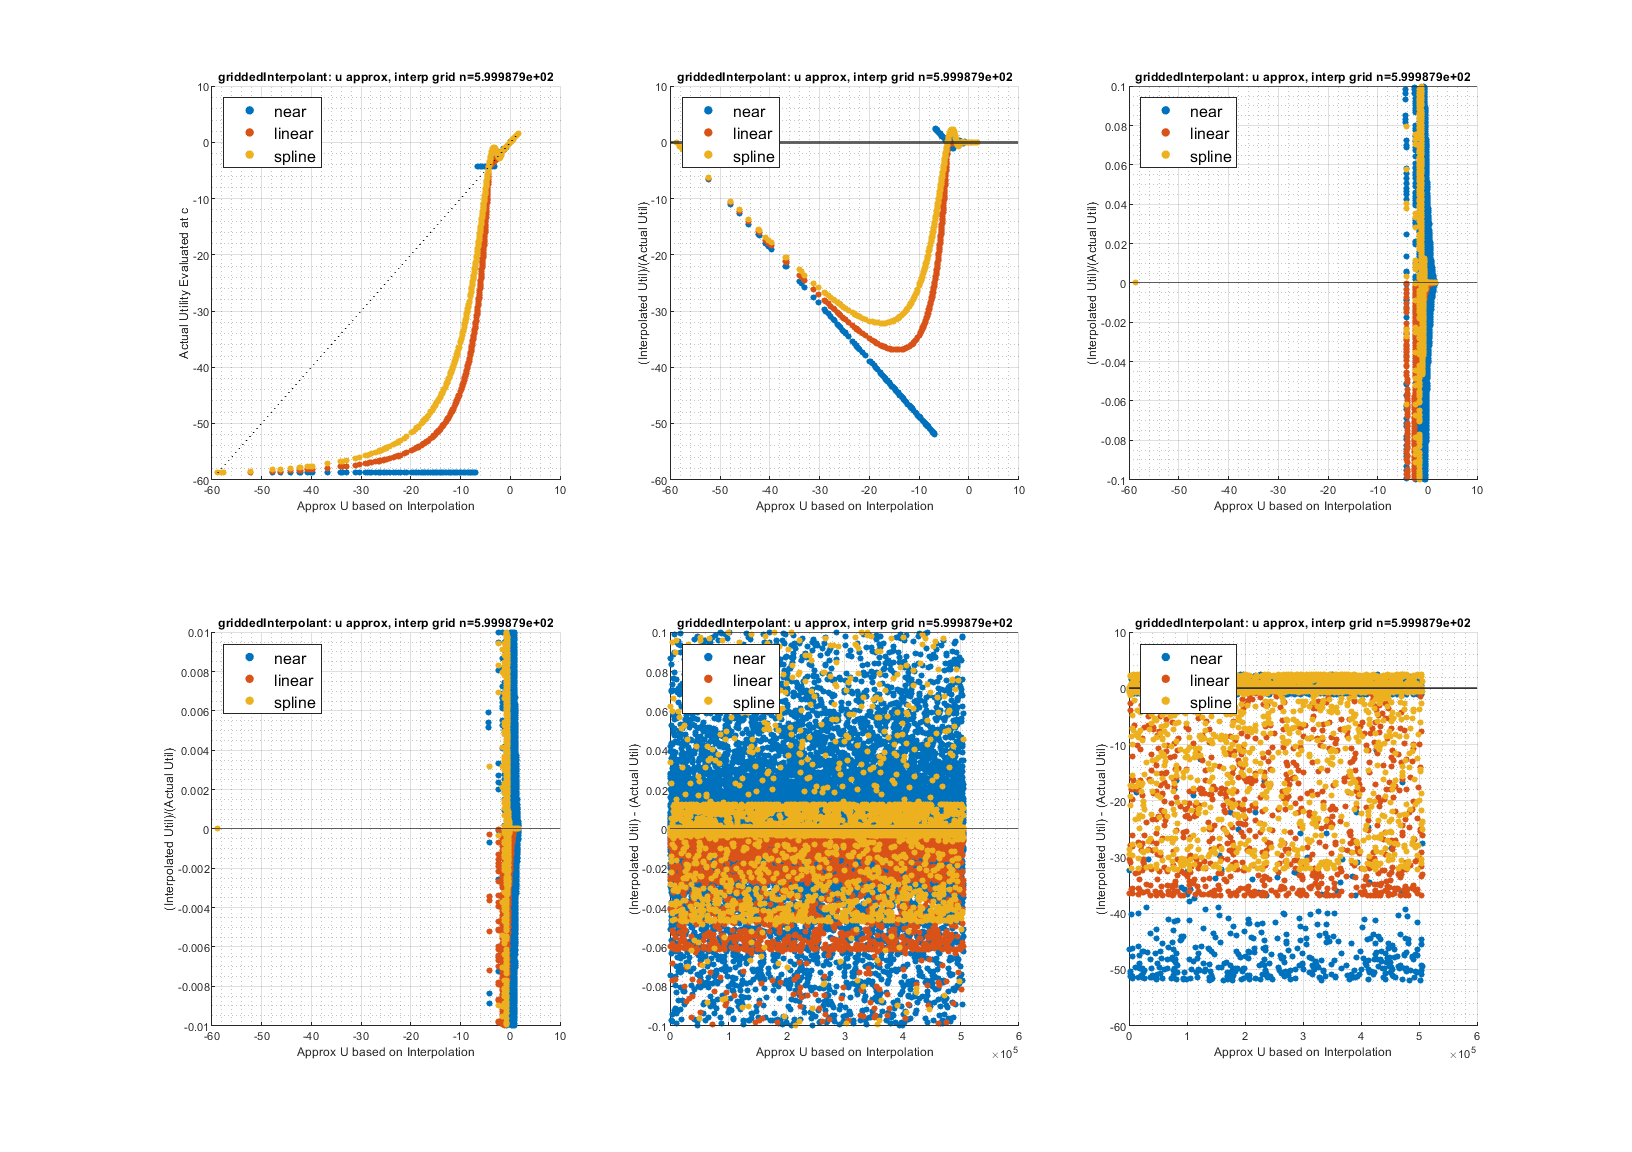

In [12]:
% 10^-1 As Interpolant Points Gap
param_map = containers.Map('KeyType','char', 'ValueType','any');
param_map('c_min') = 0.001;
param_map('c_max') = 60;
param_map('c_gap') = 10^-1;
support_map = containers.Map('KeyType','char', 'ValueType','any');
support_map('bl_graph') = true;
support_map('bl_graph_onebyones') = false;
ff_rational_exp_interp(param_map, support_map)

  griddedInterpolant with properties:

            GridVectors: {[1x59998 double]}
                 Values: [59998x1 double]
                 Method: 'nearest'
    ExtrapolationMethod: 'nearest'

  griddedInterpolant with properties:

            GridVectors: {[1x59998 double]}
                 Values: [59998x1 double]
                 Method: 'linear'
    ExtrapolationMethod: 'linear'

  griddedInterpolant with properties:

            GridVectors: {[1x59998 double]}
                 Values: [59998x1 double]
                 Method: 'spline'
    ExtrapolationMethod: 'spline'

Elapsed time is 1.799018 seconds.



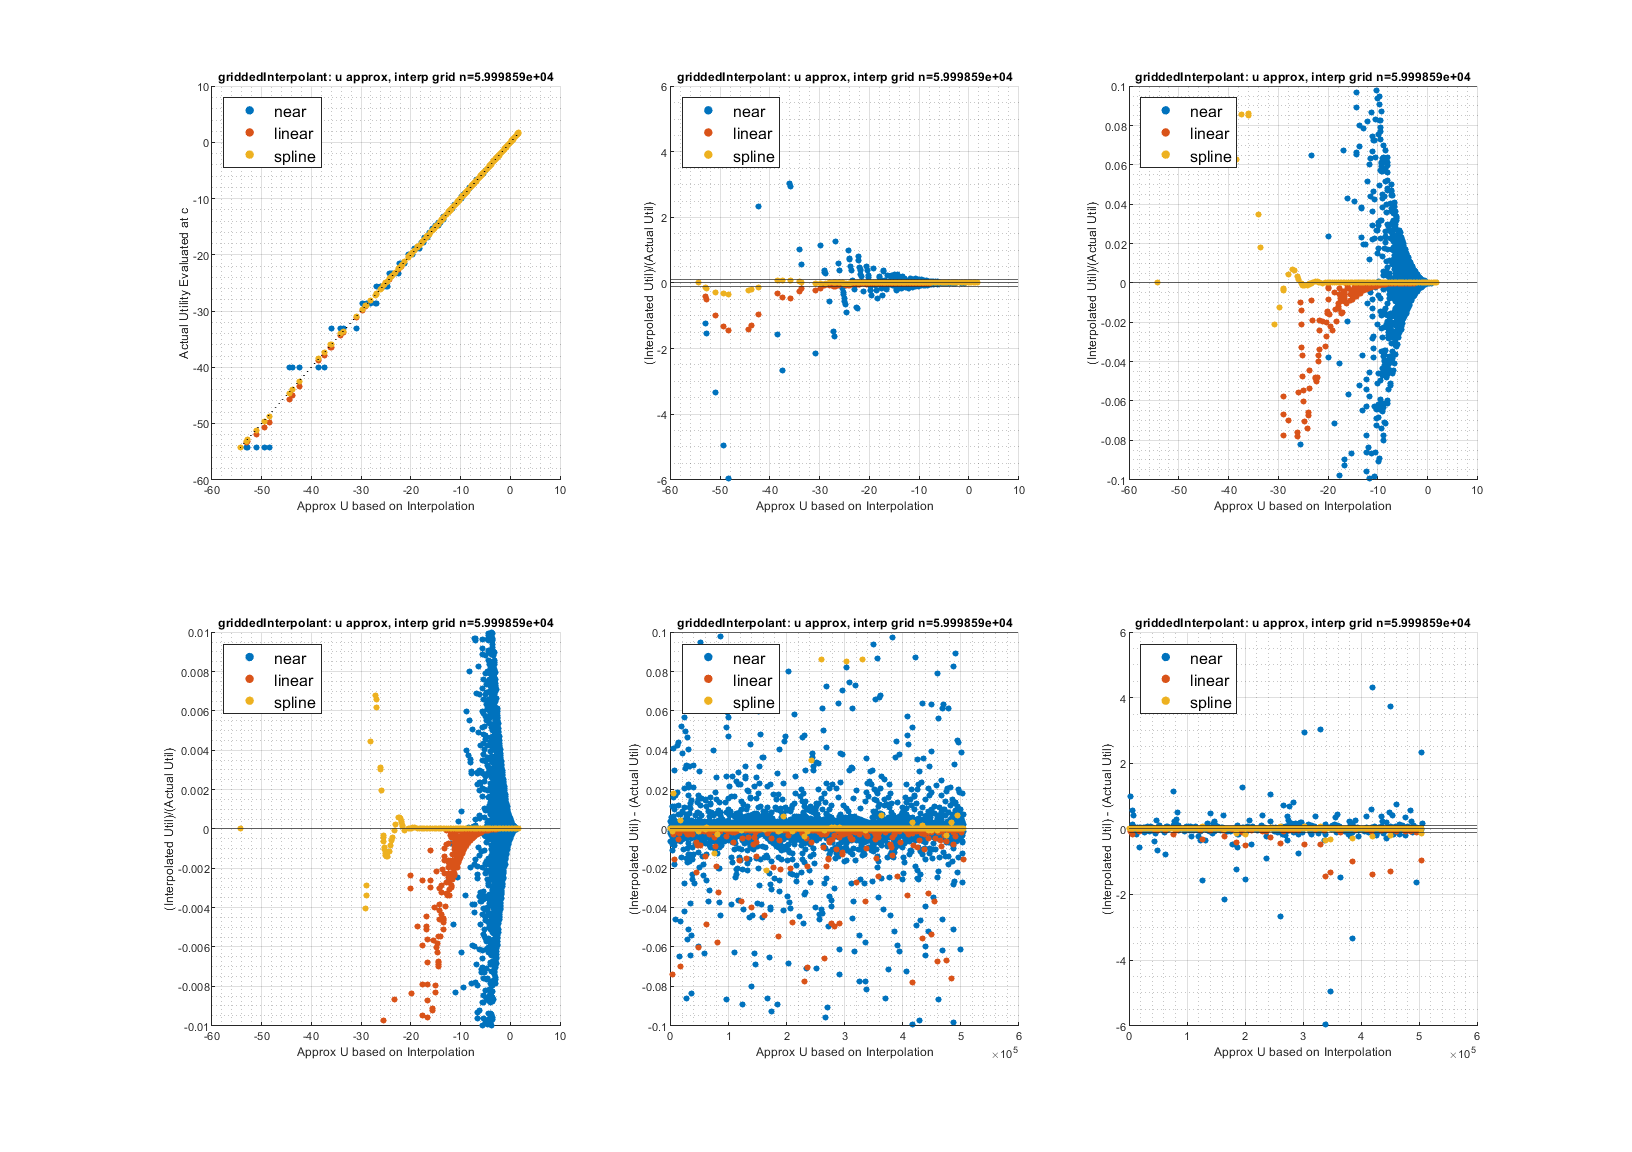

In [13]:
% 10^-3 As Interpolant Points Gap
param_map = containers.Map('KeyType','char', 'ValueType','any');
param_map('c_min') = 0.001;
param_map('c_max') = 60;
param_map('c_gap') = 10^-3;
support_map = containers.Map('KeyType','char', 'ValueType','any');
support_map('bl_graph') = true;
support_map('bl_graph_onebyones') = false;
ff_rational_exp_interp(param_map, support_map)

## Shifting Minimum Consumption Level

Minimum Consumption determines how low utility level goes. Lower minimum consumption means worse approximation.

if minc = 0.1, almost perfect, if minc = 0.001, still very good, but slightly off at very low consumption levels. 

  griddedInterpolant with properties:

            GridVectors: {[1x59899 double]}
                 Values: [59899x1 double]
                 Method: 'nearest'
    ExtrapolationMethod: 'nearest'

  griddedInterpolant with properties:

            GridVectors: {[1x59899 double]}
                 Values: [59899x1 double]
                 Method: 'linear'
    ExtrapolationMethod: 'linear'

  griddedInterpolant with properties:

            GridVectors: {[1x59899 double]}
                 Values: [59899x1 double]
                 Method: 'spline'
    ExtrapolationMethod: 'spline'

Elapsed time is 1.807600 seconds.



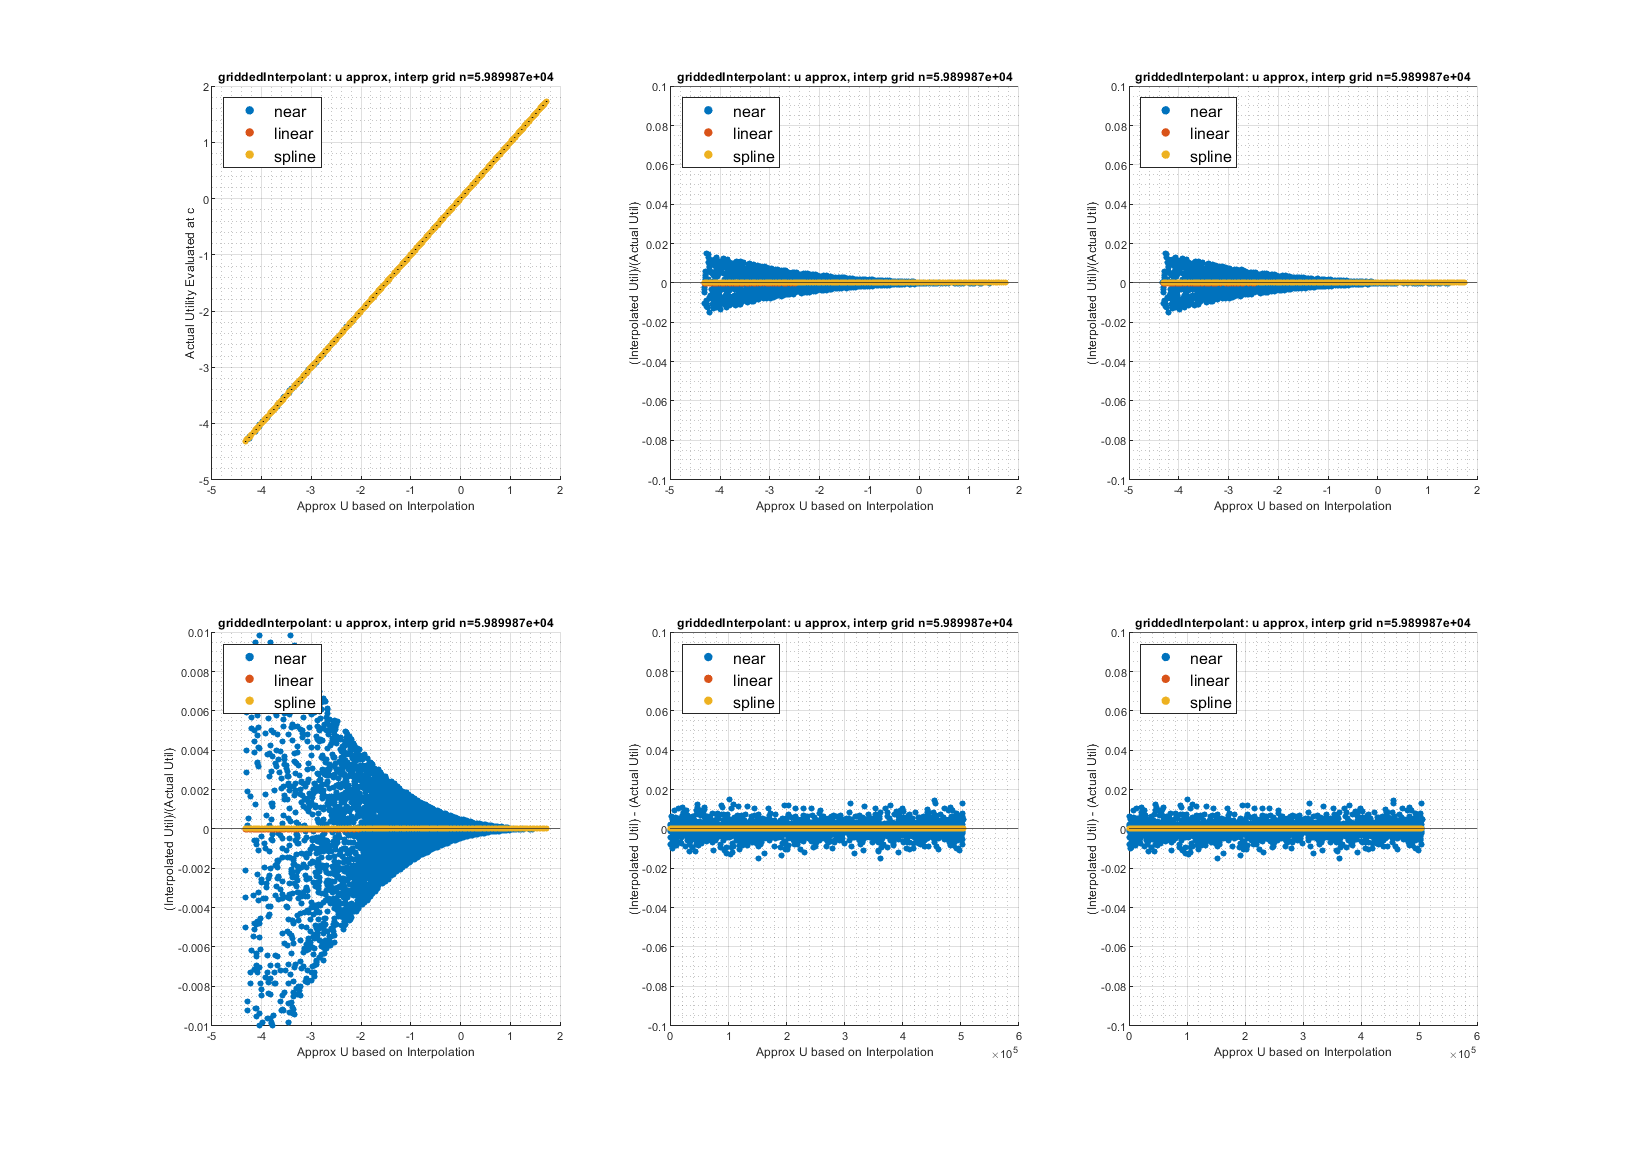

In [14]:
% 0.1 for minimum consumption
param_map = containers.Map('KeyType','char', 'ValueType','any');
param_map('c_min') = 0.1;
param_map('c_min_for_util') = param_map('c_min');
param_map('c_max') = 60;
param_map('c_gap') = 10^-3;
support_map = containers.Map('KeyType','char', 'ValueType','any');
support_map('bl_graph') = true;
support_map('bl_graph_onebyones') = false;
ff_rational_exp_interp(param_map, support_map)

  griddedInterpolant with properties:

            GridVectors: {[1x59998 double]}
                 Values: [59998x1 double]
                 Method: 'nearest'
    ExtrapolationMethod: 'nearest'

  griddedInterpolant with properties:

            GridVectors: {[1x59998 double]}
                 Values: [59998x1 double]
                 Method: 'linear'
    ExtrapolationMethod: 'linear'

  griddedInterpolant with properties:

            GridVectors: {[1x59998 double]}
                 Values: [59998x1 double]
                 Method: 'spline'
    ExtrapolationMethod: 'spline'

Elapsed time is 1.727998 seconds.



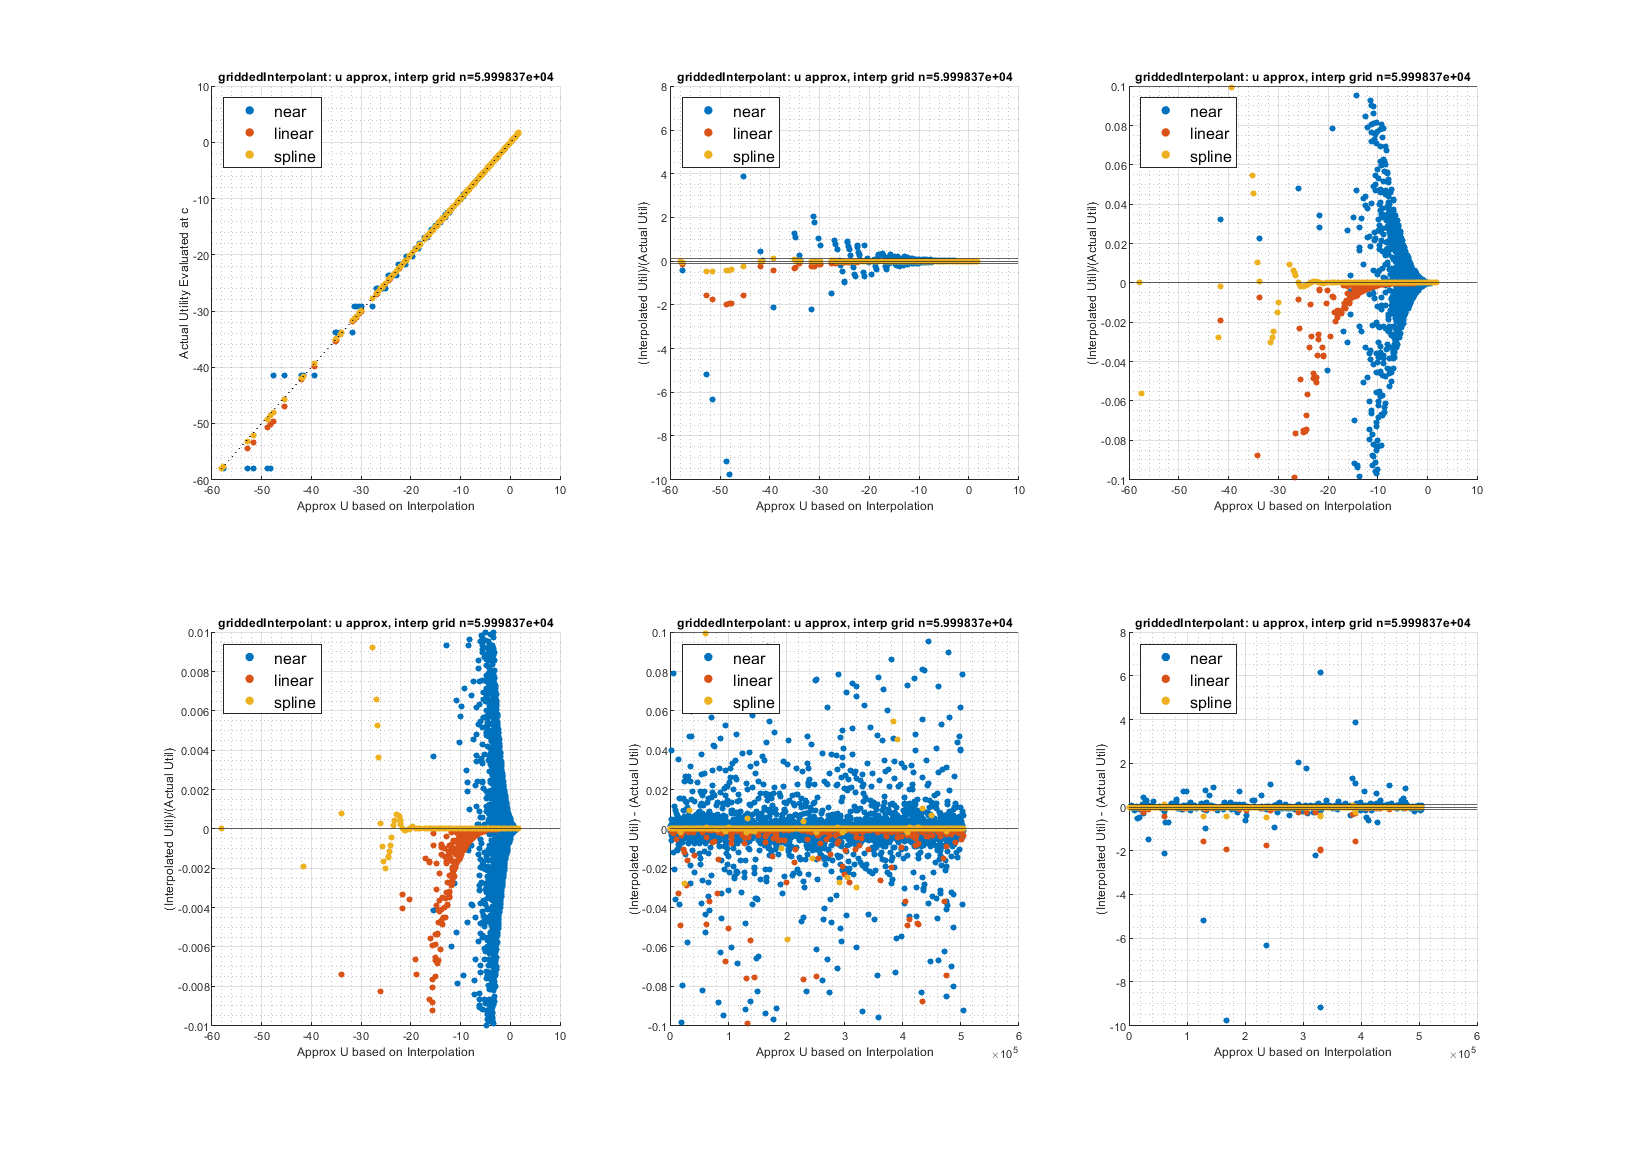

In [15]:
% 0.001 for minimum consumption
param_map = containers.Map('KeyType','char', 'ValueType','any');
param_map('c_min') = 0.001;
param_map('c_min_for_util') = param_map('c_min');
param_map('c_max') = 60;
param_map('c_gap') = 10^-3;
support_map = containers.Map('KeyType','char', 'ValueType','any');
support_map('bl_graph') = true;
support_map('bl_graph_onebyones') = false;
ff_rational_exp_interp(param_map, support_map)